## Загрузка необходимых библиотек и модулей, установка пакетов

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\maxle\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import gensim.downloader
from gensim.models import Word2Vec, KeyedVectors
from natasha import Doc, Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger

import mlxtend
from mlxtend.evaluate import paired_ttest_kfold_cv

from plotly.offline import iplot
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

In [16]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык'])

## Вспоминаем собранный датасет

In [3]:
df = pd.read_pickle('df.p', compression='gzip')

In [11]:
df.shape

(608028, 14)

In [7]:
df.sample(5)

,url,title,resume,news,date,tags,day,month_year,year,month,weekday,len_title,len_resume,len_news
462670,https://newsru.com/cinema/05may2005/pitt.html,"Шумный секс Питта и Джоли: охрана подумала, чт...","После того, как вооруженные охранники помчалис...",Голливудских звезд Брэда Питта и Анджелину Джо...,2005-05-05 14:22:00,cinema,5,2005-05,2005,May,Thursday,63,211,3401
571541,https://newsru.com/cinema/16sep2009/slon.html,Рок-музыкант Шнуров снимется в фильме о тяжело...,"Как рассказали на съемочной площадке, в фильме...","В Белоруссии начались съемки фильма ""Слон"", в ...",2009-09-16 16:29:00,cinema,16,2009-09,2009,September,Wednesday,60,240,1413
234598,https://newsru.com/world/28feb2017/israel.html,Израиль предложил арабским странам создать аль...,"Суннитские арабские страны поняли, что самую с...",Израиль предлагает Саудовской Аравии и другим ...,2017-02-28 16:32:00,world,28,2017-02,2017,February,Tuesday,79,339,210
298351,https://newsru.com/realty/15may2020/putin_snip...,Путин потребовал от правительства навести поря...,"""Я прекрасно отдаю себе отчет, что происходит ...",Президент России Владимир Путин потребовал от ...,2020-05-15 18:21:00,realty,15,2020-05,2020,May,Friday,109,259,1990
278707,https://newsru.com/russia/23dec2018/isobody.html,На шахте в Соликамске обнаружено тело девятого...,В субботу около 10:04 мск произошло задымление...,Горноспасатели подняли на поверхность тела шес...,2018-12-23 11:52:00,russia,23,2018-12,2018,December,Sunday,56,235,318


In [12]:
df.tags.value_counts()

world      180612
russia     180284
sport       77344
finance     57753
cinema      39744
auto        25209
realty      23714
hitech      23368
Name: tags, dtype: int64

## Постановка задачи
Это вторая часть работы в рамках курса по NLP, которая посвящена решению задачи классификации на основе собранного в первой части датасета новостей с ресурса newsru.com. Реализация сбора датасета и его подробный анализ был сделан на предыдущем этапе, вы можете посмотреть его в этом же репозитории в ноутбуке 'newsrucom_dataset_eda'.  

Построение классификатора требует сам собранный датасет. Напомним, что основные его категории хранятся в столбце tag. Вот они: ['world', 'russia', 'sport', 'finance', 'cinema', 'auto', 'realty', 'hitech']. Категории 'world' и russia' по сути являются агрегирующими, и состоят из политических новостей и значительной примесью новостей из прочих категорий, обозначенных выше (похожая ситуация в эталонном ноутбуке, именно эти категории хуже всего определяются классификаторами согласно корряляционной матрице. Наличие таких категорий не даёт пользователю понимание характера новости без её прочтения, поэтому наша задача заменить эти две агрегирующие категории на нормальные монокатегории 'sport', 'finance', 'cinema', 'auto', 'realty', 'hitech' и 'polytics', для чего мы построим разные классификаторы, определим лучший из них и применим лучшую обученную модель классификации на новости, имеющие категории. 

Но откуда взять категорию "политика", которая отсутствует в нашем датасете? Для этого мы применим готовый обученный классификатор, который "знает" категории ['polytics', 'science', 'sport', 'economy', 'entertainment', 'other', 'not_news', 'technology'] к строкам из наших категорий 'world' и 'russia', и отберем среди тех новостей, которым классификатор присвоит категорию 'polytics', небольшую часть для обучения наших классификаторов. После обучения присвоим всем оставшимся новостям из этих агрегирующих категорий новые категории.      


Таким образом, 
## План действий:
1. Отобрать в Train по 20_000 новостей из категорий 'sport', 'finance', 'cinema', 'auto', 'realty', 'hitech'. 
2. Обучить готовый классификатор fasttext на новостях категорий 'world' и 'russia', отобрать из них 20_000 новостей с категорией 'polytics' и добавить к Train. Train мы поделим ещё раз на ту часть, на которой будет обучаться (train с маленькой буквы и валидационную часть, на которой будем оценивать качество). У оставшихся новостей удалим категории. Это будет наша целевая выборка Test, куда мы будем применять лучшую модель классификации по итогам валидации (так получим новые значения категорий взамен 'world' и 'russia').
3. Обучим несколько разных моделей эмбеддингов и классификаторов, и оценим их качество классификации:
* world2vec + логистическая регрессия
* обученный не мной fasttext + SVM
* обученный в supervised режиме классификатор fasttext
4. Применим лучшую модель к нашим новостям из датасета Train. 
5. Делаем общие выводы    

### 1-2. Создаём Train и Test  
Тут было куча кода работы в Pandas по удалению ненужных столбцов, отбору части строк, разделению датасетов и их частичному объединению. Не стал их включать в итоговый ноутбук, т.к. это не профильная заданию работа, а грязного кода она наплодила много. Посмотрим сразу на итоговые датасеты.  

In [2]:
Train = pd.read_pickle('train.p', compression='gzip')

In [4]:
Train.shape

(330980, 3)

In [7]:
Train.head(5)

,title,resume,target
0,Российский рынок акций закрылся выше уровня от...,"Аналитики считают, что следующая сессия должна...",finance
1,В США распродали личные вещи Элвиса. Прядь вол...,Накануне в Чикаго ушли с молока около 200 личн...,cinema
2,Евросоюз отказывается от меха кошек и собак,Европарламент наложил запрет на торговлю одежд...,finance
3,Спилберг и Лукас превратили Нью-Мексико в Марокко,"В США начались съемки четвертой части фильма ""...",cinema
4,По делу Hapoalim предъявлено обвинение бизнесм...,"Бориса Хаита, владельца крупной российской стр...",finance


In [8]:
Train.target.value_counts()

polytics    83848
sport       77344
finance     57753
cinema      39744
auto        25209
realty      23714
hitech      23368
Name: target, dtype: int64

In [3]:
Test = pd.read_pickle('test.p', compression='gzip')

In [9]:
Test.head(5)

,title,resume,target
0,"Источники настаивают, что Капков покинет свой ...",Среди версий причин якобы грядущей отставки Се...,unknown
1,"Мэр Кемерово в программе ""Мы вас слышим"" посов...",В последние выходные февраля в Кемеровской обл...,unknown
2,В Египте казнили первого из приговоренных к см...,Махмуд Рамадам признан виновным в расправе над...,unknown
3,В приемные трех канадских министров пришли кон...,"""Опасные письма"" предназначались членам правящ...",unknown
4,"МЧС посылает на Донбасс ""адресный"" гумконвой с...","МЧС ""направляет в Донецк своих представителей,...",unknown


In [11]:
Test.target.value_counts()

unknown    234046
Name: target, dtype: int64

Т.е. наша основная задача - заполнить категории в столбце target лучшей моделью. 

Кстати, наш train получился несбалансированным по категориям. Забыл отобрать по 20_000 новостей, чтобы классификаторы определяли категории равновероятно. Исправляюсь  

In [10]:
final_train = Train.groupby('target').sample(20_000)

In [11]:
final_train.target.value_counts()

auto        20000
cinema      20000
finance     20000
hitech      20000
polytics    20000
realty      20000
sport       20000
Name: target, dtype: int64

Теперь ок. Сохраняем финальный тренировочный датафрейм на диск.

In [27]:
final_train.to_pickle('final_train.p', compression='gzip')

### 3. Тренируем модели эмбедденгов и классификации
#### 3.1. Word2vec + логистическая регреессия 

In [17]:
def text_prep(text) -> str:
    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    lemmas = [_.lemma for _ in doc.tokens]
    words = [lemma for lemma in lemmas if lemma.isalpha() and len(lemma) > 2]
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [32]:
final_train['title_clean'] = final_train.title.apply(text_prep)
final_train['resume_clean'] = final_train.resume.apply(text_prep)

In [22]:
final_train.sample(5)

,title,resume,target,title_clean,resume_clean
95479,Продажи Lada Granta с новой трансмиссией старт...,Волжский автомобильный завод планирует расшири...,auto,продажа lada granta новый трансмиссия стартова...,волжский автомобильный завод планировать расши...
51999,"Музей западного искусства создадут, но виртуал...","""Совместим все коллекции, во всяком случае то,...",cinema,музей западный искусство создать виртуальный к...,совместимый коллекция всякий случай остаться с...
194640,Спор федеральных и местных властей о принадлеж...,На этой неделе КС должен разрешить имущественн...,realty,спор федеральный местный власть принадлежность...,неделя должный разрешить имущественный спор пр...
316404,В Мехико запретили цирковые выступления с учас...,"С понедельника, 9 июня, зрителям, пришедшим на...",polytics,мехико запретить цирковой выступление участие ...,понедельник июнь зритель прийти представление ...
70660,"В Швеции состоялся первый концерт группы, инст...",Инициатором выступления стал профессор Лундско...,hitech,швеция состояться первый концерт группа инстру...,инициатор выступление стать профессор лундский...


In [33]:
final_train.to_pickle('final_train.p', compression='gzip')

In [34]:
final_train.sample(1)[['title', 'title_clean']].values

array([['Шакил О`Нил стал офицером запаса полиции Майами',
        'шакил нил стать офицер запас полиция майами']], dtype=object)

In [35]:
final_train.sample(1)[['resume', 'resume_clean']].values

array([['Мужская сборная России провела заключительный матч группового этапа чемпионата мира по гандболу. Во встрече с французами россияне оказали достойное сопротивление действующим чемпионам мира и уступили с минимальным счетом.',
        'мужской сборная россия провести заключительный матч групповой этап чемпионат мир гандбол встреча француз россиянин оказать достойный сопротивление действовать чемпион мир уступить минимальный счет']],
      dtype=object)

Пробуем разные параметры моделей. При этом строим модели и на корпусе заголовков (model_title) и корпусе резюме (model_resume). Корпус резюме содержит больше слов для тренировки модели, получатся ли эмбеддинги качественнее? 

In [36]:
model_resume = Word2Vec(sentences=final_train.resume_clean.str.split(),
                 vector_size=300,
                 min_count=10,
                 window=5)

In [48]:
model_resume.wv.most_similar(positive=["исследование"])

[('опрос', 0.813247561454773),
 ('анализ', 0.8111065626144409),
 ('социологический', 0.6865130066871643),
 ('аналитический', 0.6860990524291992),
 ('мониторинг', 0.6806802153587341),
 ('iihs', 0.679487943649292),
 ('ncap', 0.6530512571334839),
 ('эксперимент', 0.6486611366271973),
 ('изучение', 0.6429582238197327),
 ('исследовательский', 0.6425201296806335)]

In [49]:
model_resume.wv.most_similar(positive=["нефть"])

[('сырье', 0.7905601859092712),
 ('нефтепродукт', 0.752928614616394),
 ('газ', 0.7388834953308105),
 ('нефтяной', 0.6947216987609863),
 ('добыча', 0.6897706985473633),
 ('зерно', 0.6868805289268494),
 ('экспорт', 0.6848858594894409),
 ('экспортный', 0.683884859085083),
 ('энергоноситель', 0.6759960651397705),
 ('баррель', 0.6746608018875122)]

In [37]:
model_title = Word2Vec(sentences=final_train.title_clean.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2)

In [47]:
model_title.wv.most_similar(positive=["нейросеть"])

[('алгоритм', 0.9847061038017273),
 ('пылесос', 0.9826249480247498),
 ('ветряный', 0.9814181923866272),
 ('перчатка', 0.9813777208328247),
 ('конструктор', 0.980202317237854),
 ('стильный', 0.979066014289856),
 ('шутер', 0.9786944389343262),
 ('творение', 0.9779321551322937),
 ('фотокамера', 0.9774936437606812),
 ('генератор', 0.9769431948661804)]

In [11]:
model_resume = Word2Vec(sentences=df.resume_clean.str.split(),
                 vector_size=300,
                 min_count=10,
                 window=5)

In [12]:
model_resume.wv.most_similar(positive=["эмиграция"])

[('эмигрант', 0.6433151364326477),
 ('эмигрировать', 0.6282538175582886),
 ('любить', 0.4736933410167694),
 ('распад', 0.45340558886528015),
 ('диссидент', 0.4515165090560913),
 ('стереотип', 0.4482625126838684),
 ('прошлое', 0.4463880956172943),
 ('капитализм', 0.44509032368659973),
 ('потомок', 0.44043004512786865),
 ('евроскептик', 0.4370778203010559)]

In [28]:
model_title = Word2Vec(sentences=df.title_clean.str.split(),
                 vector_size=200,
                 min_count=10,
                 window=2)

In [29]:
model_title.wv.most_similar(positive=["эмиграция"])

[('стареть', 0.7895634174346924),
 ('застой', 0.7767952680587769),
 ('сбыться', 0.7641559839248657),
 ('автоновинка', 0.7517094612121582),
 ('утроиться', 0.7477977871894836),
 ('доживать', 0.7451843023300171),
 ('вымирать', 0.741502583026886),
 ('прибавиться', 0.7328689694404602),
 ('раскупать', 0.7317813634872437),
 ('страховаться', 0.7294740080833435)]

In [73]:
model_title.wv.most_similar(positive=["эмиграция"])

[('сочувствие', 0.7610095143318176),
 ('автоновинка', 0.7607506513595581),
 ('переводиться', 0.7602695226669312),
 ('застой', 0.7532272338867188),
 ('сбыться', 0.7518793344497681),
 ('эйфория', 0.750816822052002),
 ('раздражение', 0.7491551637649536),
 ('каприз', 0.7475816011428833),
 ('смута', 0.7424665689468384),
 ('семнадцать', 0.7409263253211975)]

В результате экспериментов с различными параметрами мне больше всего субъективно нравятся эмбеддинги, полученные из резюме с параметрами vector_size=300, min_count=10, window=5. 

Для обучения и моделей эмбедденгов, и моделей классификации, нам предлагалось делить датасет на трейн и тест, и обучать обе модели только на трейне. Принципиально не согласен с этим условием, и писал об этом на stepik. Поясню свою позицию. Чтобы классификатор нормально работал, у него должны быть очень хорошие эмбедденги, т.е. представления слов в векторном пространстве. Представление будет тем лучше, чем больше корпус текста увидит модель на обучении. Для решения различных задач NLP берут как правило самые качественные эмбеддинги (если нет технических ограничений по объему модели и её скорости). Задача классификации - совершенно иная задача. Нам важно чтобы именно классификатор не знал конкретный пример классификации текста, а то, что он знает эмбедденг слов, из которых текст состоит, так так и должно быть, это хорошо! Я понимаю, что за это могут снизить оценку, но делаю это осознанно. 

Итак, буду обучать модель эмбеддингов на всём корпусе текстов с параметрами, которые посчитал как оптимальные.

In [11]:
df_big = pd.read_pickle('df_big.p', compression='gzip')

In [16]:
model_resume = Word2Vec(sentences=df_big.resume_clean.str.split(),
                        vector_size=300,
                        min_count=10,
                        window=5)
model_resume.wv.most_similar(positive=["эмиграция"])

[('эмигрант', 0.6088088154792786),
 ('эмигрировать', 0.5850927233695984),
 ('любить', 0.5510222315788269),
 ('евроскептик', 0.47467872500419617),
 ('потомок', 0.472459614276886),
 ('увлечение', 0.47232872247695923),
 ('любовь', 0.4710487127304077),
 ('диссидент', 0.470294326543808),
 ('сниться', 0.4663284122943878),
 ('прошлое', 0.45655474066734314)]

Очень классные синомины, мне нравится. 
А теперь наш Трейн делим на собственно трейн и валидацию. На трейн будем обучать классификаторы, на валидации подбирать оценивать качество и подбирать параметры

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.resume_clean.str.split(),
                                                    df.target.values, test_size=0.3, stratify=df.target.values,
                                                    random_state=42)

In [26]:
X_test

262956    [прицел, камера, пит, сауза, личный, фотограф,...
247372    [заявить, лидер, трудовой, россия, виктор, анп...
150944    [случай, всемирный, день, книга, немецкий, авт...
108687    [ранее, возможность, вести, трансляция, соцсет...
77672     [невыездной, делать, россиянин, репрессивный, ...
                                ...                        
161447    [работа, собрание, семья, художница, разительн...
219751    [стоимость, российский, нефть, упасть, ход, то...
101428    [опубликовать, сеть, видеоролик, усовершенство...
144081    [делаться, столько, любовь, клиент, сколько, п...
140733    [спутник, запустить, площадка, расположить, ко...
Name: resume_clean, Length: 42000, dtype: object

In [27]:
y_test.shape[0]/7

6000.0

Эмбедденги предложения пропоциональны весам tfidf:

In [7]:
class TfidfEmbeddingVectorizer(object):
    """Get tfidf weighted vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.word2weight = None
        self.dim = model.vector_size

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec.get_vector(w) * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

Применяем логистическую регреесию на tfidf эмбеддингах предложений:

In [22]:
pipe = Pipeline([('w2v', TfidfEmbeddingVectorizer(model_resume)),
                 ('clf', LogisticRegression(random_state=42,
                                            max_iter=10000))])

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

        auto       0.88      0.84      0.86      6000
      cinema       0.87      0.87      0.87      6000
     finance       0.77      0.81      0.79      6000
      hitech       0.85      0.86      0.85      6000
    polytics       0.74      0.78      0.76      6000
      realty       0.83      0.81      0.82      6000
       sport       0.96      0.94      0.95      6000

    accuracy                           0.84     42000
   macro avg       0.84      0.84      0.84     42000
weighted avg       0.84      0.84      0.84     42000


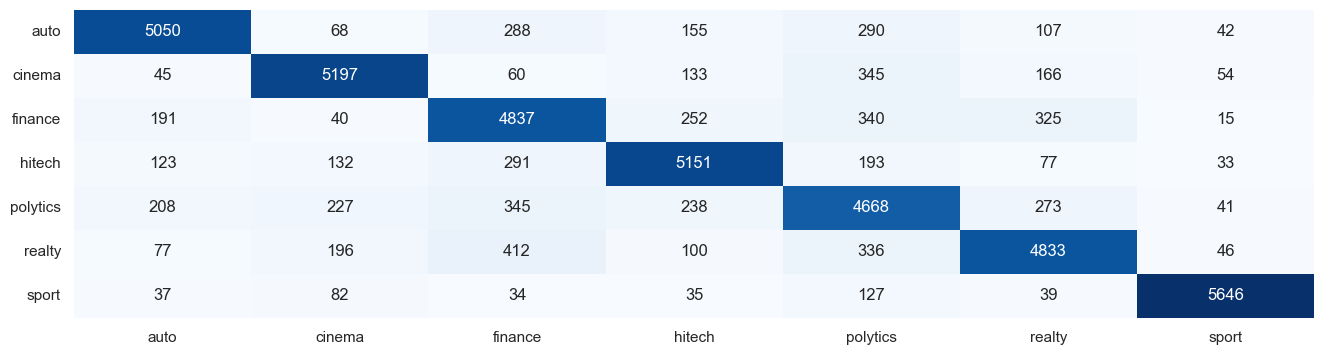

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe.predict(X_test), labels=pipe.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe.classes_, index=pipe.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

Качество неплохое. Путаем чаще всего категорию политику (ну так она, как правило, и самая размытая, так что ок)

Теперь считаем эмбедденги предложение, как простое среднее.

In [28]:
class MeanEmbeddingVectorizer(object):
    """Get mean of vectors"""
    def __init__(self, model):
        self.word2vec = model.wv
        self.dim = model.vector_size

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.get_vector(w)
                for w in words if w in self.word2vec] or
                [np.zeros(self.dim)], axis=0)
            for words in X])

In [29]:
pipe2 = Pipeline([('w2v', MeanEmbeddingVectorizer(model_resume)),
                 ('clf', LogisticRegression(random_state=42,
                                            max_iter=1000))])

pipe2.fit(X_train, y_train)

print(classification_report(y_test, pipe2.predict(X_test)))

              precision    recall  f1-score   support

        auto       0.88      0.84      0.86      6000
      cinema       0.87      0.86      0.87      6000
     finance       0.77      0.80      0.79      6000
      hitech       0.85      0.86      0.85      6000
    polytics       0.74      0.77      0.75      6000
      realty       0.83      0.80      0.82      6000
       sport       0.96      0.94      0.95      6000

    accuracy                           0.84     42000
   macro avg       0.84      0.84      0.84     42000
weighted avg       0.84      0.84      0.84     42000


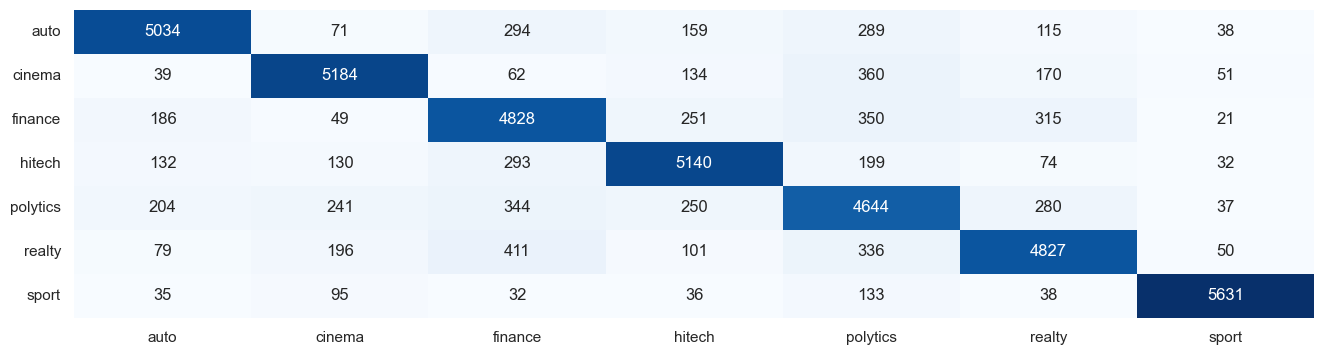

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pipe2.predict(X_test), labels=pipe2.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe2.classes_, index=pipe2.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

Качество практически аналогичное, но confusion matrix tfidf мне нравится чуть получше. Оставляем это сочетание как лучшее для w2v

#### 3.2. Fasttext + SVM 

In [33]:
from gensim.models.fasttext import FastText as FT_gensim

По-преженму пробуем обучать эмбедденги на текстах резюме и заголовках новостей. 

Чтобы обучить эмбедденги fasttext, нужно передавать в объявленную модель список списков предложений. Для этого требуется вот это: 

In [22]:
corpus_title = [s.split() for s in df['title_clean'].values.tolist()]

In [23]:
model_gensim = FT_gensim(vector_size=150, negative=15, window=20, min_count=1)
model_gensim.build_vocab(corpus_title)
# model_gensim

In [24]:
model_gensim.wv.most_similar('эмиграция')

[('миграция', 0.7627847194671631),
 ('иммиграция', 0.6453176140785217),
 ('эмиграционный', 0.5673359632492065),
 ('эмигрант', 0.5608475208282471),
 ('эмигрантка', 0.5087839961051941),
 ('эмигрантский', 0.4644589126110077),
 ('перлюстрация', 0.4562194347381592),
 ('операция', 0.44811785221099854),
 ('миграционный', 0.444167822599411),
 ('агломерация', 0.41208770871162415)]

In [6]:
corpus = [s.split() for s in df['resume_clean'].values.tolist()]

In [9]:
model_gensim_resume = FT_gensim(vector_size=300, negative=10, window=5)
model_gensim_resume.build_vocab(corpus)

In [10]:
model_gensim_resume.wv.most_similar('эмиграция')

[('миграция', 0.7622491717338562),
 ('иммиграция', 0.6979402899742126),
 ('грация', 0.5979841351509094),
 ('эмиграционный', 0.511577308177948),
 ('рация', 0.4936811327934265),
 ('операция', 0.46507641673088074),
 ('аэрация', 0.46436619758605957),
 ('кооперация', 0.45765867829322815),
 ('эмигрант', 0.4496615529060364),
 ('интеграция', 0.4477916359901428)]

Обученная на таких параметрах модель для классификации плохая. Модель по-умолчанию обучается на биграммах, и склонна скорее считать близкими однокоренные слова, а не синонимы, что нам так нужно в задачах классификации. Начинам подбирать параметры модели, которые нас больше устроят.

In [14]:
ft_news = [s.split() for s in df['resume'].values.tolist()]
model_resume = FT_gensim(vector_size=128, window=2, min_n=2)
model_resume.build_vocab(ft_news)
model_resume.wv.most_similar('эмиграция')

[('миграция', 0.7666358947753906),
 ('эмиграцию', 0.6886281967163086),
 ('эмиграции', 0.6862261295318604),
 ('эмиграции.', 0.6505776047706604),
 ('эмиграции,', 0.6427459716796875),
 ('иммиграция', 0.5888344645500183),
 ('эмигрантов.', 0.5328771471977234),
 ('эмигранты', 0.5292487144470215),
 ('эмигрантов', 0.497592955827713),
 ('эмигрантов,', 0.4900228977203369)]

In [13]:
ft_news = [s.split() for s in df['resume'].values.tolist()]
model_resume = FT_gensim(vector_size=128, window=2, min_n=4)
model_resume.build_vocab(ft_news)
model_resume.wv.most_similar('эмиграция')

[('миграция', 0.6971770524978638),
 ('эмиграции', 0.6677354574203491),
 ('эмиграцию', 0.6438403725624084),
 ('эмиграции,', 0.5940139889717102),
 ('эмиграции.', 0.5684981346130371),
 ('эмигрантов.', 0.5125205516815186),
 ('эмигранты', 0.506153404712677),
 ('иммиграция', 0.50594162940979),
 ('эмигрантов,', 0.4788435399532318),
 ('эмигранты,', 0.4725164771080017)]

In [25]:
ft_news = [s.split() for s in df['resume'].values.tolist()]
model_resume = FT_gensim(vector_size=128, window=4, min_n=6)
model_resume.build_vocab(ft_news)
model_resume.wv.most_similar('эмиграция', topn=20)

[('миграция', 0.5794048309326172),
 ('иммиграция', 0.5505046248435974),
 ('эмиграции', 0.5035000443458557),
 ('эмиграции.', 0.48453158140182495),
 ('эмиграции,', 0.482930064201355),
 ('эмиграцию', 0.4390946924686432),
 ('богаты', 0.3689899444580078),
 ('тарифу', 0.36751362681388855),
 ('эмигранты,', 0.3657795190811157),
 ('увлечение', 0.36109238862991333),
 ('"операция', 0.3577500283718109),
 ('иммиграционным', 0.34252482652664185),
 ('оппозиционер,', 0.34169140458106995),
 ('неудовлетворенных', 0.3416306674480438),
 ('Гуйчжоу', 0.3408966064453125),
 ('сектору,', 0.33840277791023254),
 ('дефицитов', 0.3374575078487396),
 ('стоимости.', 0.3349628746509552),
 ('Марсе', 0.3315269351005554),
 ('Бушем', 0.3298052251338959)]

In [34]:
ft_news = [s.split() for s in df_big.resume.values.tolist()]
model_resume = FT_gensim(vector_size=128, window=4, min_n=6)
model_resume.build_vocab(ft_news)
model_resume.wv.most_similar('эмиграция', topn=20)

[('миграция', 0.5794048309326172),
 ('иммиграция', 0.5505046248435974),
 ('эмиграции', 0.5035000443458557),
 ('эмиграции.', 0.48453158140182495),
 ('эмиграции,', 0.482930064201355),
 ('эмиграцию', 0.4390946924686432),
 ('богаты', 0.3689899444580078),
 ('тарифу', 0.36751362681388855),
 ('эмигранты,', 0.3657795190811157),
 ('увлечение', 0.36109238862991333),
 ('"операция', 0.3577500283718109),
 ('иммиграционным', 0.34252482652664185),
 ('оппозиционер,', 0.34169140458106995),
 ('неудовлетворенных', 0.3416306674480438),
 ('Гуйчжоу', 0.3408966064453125),
 ('сектору,', 0.33840277791023254),
 ('дефицитов', 0.3374575078487396),
 ('стоимости.', 0.3349628746509552),
 ('Марсе', 0.3315269351005554),
 ('Бушем', 0.3298052251338959)]

Вот! То, что нужно! (но всё равно ощутимо хуже w2v). Итак, определяющим параметром для перехода близости векторов к синонимам является нижняя граница длины символа ngrams. Чем больше делаем её в сторону 6-8, тем лучше. Т.е. по сути мы фасттекст приближаем к w2v )) (т.к. начинаем работать почти со словом). Верхнюю границу лучше не трогать, результат портится. Дополнительно имеет смысл сужать окно контекста, иначе получаются эмбеддинги с очень широкими трактовками

Обученную модель можно сохранить. Заметим также, что она даёт возможность получить эмбедденг предложения. Т.е. можно не реализовывать никакие дополнительные классы для применения моделей классификации: 

In [35]:
model_resume.save('model_fasttext')

In [36]:
model_resume.wv.get_sentence_vector('Я иду шагаю по Москве')

array([-0.00658096,  0.01200651, -0.00053269,  0.03362887, -0.03435837,
       -0.00996304,  0.01032217, -0.01694142, -0.00968684,  0.01835924,
       -0.00565532, -0.00273679,  0.03218921, -0.02999225, -0.023324  ,
       -0.0027044 ,  0.02004265,  0.01452905,  0.00031219,  0.00589322,
       -0.00196308,  0.03688352,  0.02671223,  0.0087174 ,  0.00724241,
       -0.0127998 , -0.03832365, -0.01420613,  0.00332896, -0.01395229,
       -0.0192947 ,  0.01719813, -0.02929882, -0.00857733,  0.0087971 ,
        0.01686338,  0.02645378,  0.01588601,  0.04112485, -0.00226715,
        0.0175296 , -0.00534464, -0.00078812, -0.00582195, -0.01193675,
        0.02438665, -0.03258744, -0.00989141, -0.02179253,  0.00800219,
        0.00717603, -0.00876605,  0.01979831, -0.00309639,  0.01247602,
       -0.00151482, -0.00957064,  0.02061344, -0.00553162,  0.00803155,
        0.00548541, -0.00895244,  0.01148622, -0.00071001,  0.01153328,
       -0.04109903,  0.0067871 , -0.01440693,  0.02881842, -0.02

In [37]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

C = np.arange(0.01, 10.01, 0.25)



In [ ]:
cross_val_score(SVC(kernel='linear', C=0.01), X_test, y_test, cv=3, scoring='roc_auc', verbose=2).mean()

Получаем из массива текстов массив чисел, соответствующих эмбедденгам предложений согласно обученной модели

In [47]:
my_array = np.array([model_resume.wv.get_sentence_vector(sent) if len(sent) else np.zeros(128) for sent in X_train.values])  

In [48]:
my_array

array([[-0.00824957,  0.01441955,  0.00711349, ..., -0.02504516,
        -0.01854455,  0.00121485],
       [-0.01311204,  0.01013994,  0.00816222, ..., -0.01612324,
        -0.00108645,  0.01020186],
       [-0.00514266,  0.00992168, -0.00201354, ..., -0.01850727,
        -0.01293971,  0.00879162],
       ...,
       [-0.00786879,  0.00883385,  0.00537049, ..., -0.02270467,
        -0.01762635,  0.00162497],
       [-0.00166247,  0.00245798,  0.00165869, ..., -0.01121567,
        -0.01268107,  0.00620194],
       [-0.00845154,  0.01247078,  0.00146211, ..., -0.02113447,
        -0.00523959,  0.00834402]])

Обучим тогда эмбедденги предложений нашего трейна методом опорных векторов (реализации SGD, которая обучается с помощью градиентного спуска).

In [50]:
from sklearn.linear_model import SGDClassifier
test_model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter_no_change=5, random_state=42)

In [52]:
test_model.fit(my_array, y_train)

SGDClassifier(alpha=0.001, random_state=42)

In [54]:
test_array = np.array([model_resume.wv.get_sentence_vector(sent) if len(sent) else np.zeros(128) for sent in X_test.values]) 

In [55]:
y_preds = test_model.predict(test_array)

In [56]:
y_preds

array(['finance', 'finance', 'finance', ..., 'finance', 'finance',
       'finance'], dtype='<U8')

In [61]:
y_test

array(['polytics', 'polytics', 'cinema', ..., 'hitech', 'finance',
       'hitech'], dtype=object)

In [70]:
labels = df.target.value_counts().index.tolist()

In [ ]:
cm = confusion_matrix(y_test, y_preds, labels=pipe2.classes_)

cm_df = pd.DataFrame(data=cm, columns=pipe2.classes_, index=pipe2.classes_)

plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

In [75]:
cm = confusion_matrix(y_test, y_preds)

In [76]:
cm

array([[  74,    4, 5548,  362,    0,    0,   12],
       [   2,  319, 5496,  102,    1,    0,   80],
       [   7,   33, 5809,   96,    0,    0,   55],
       [   8,   22, 5154,  796,    0,    0,   20],
       [   0,   24, 5920,   16,    1,    0,   39],
       [   4,   19, 5894,   58,    0,    0,   25],
       [   1,   84, 5160,   20,    0,    0,  735]], dtype=int64)

In [72]:
cm_df = pd.DataFrame(data=cm, columns=labels, index=labels)

In [74]:
cm_df

,auto,cinema,finance,hitech,polytics,realty,sport
auto,74,4,5548,362,0,0,12
cinema,2,319,5496,102,1,0,80
finance,7,33,5809,96,0,0,55
hitech,8,22,5154,796,0,0,20
polytics,0,24,5920,16,1,0,39
realty,4,19,5894,58,0,0,25
sport,1,84,5160,20,0,0,735


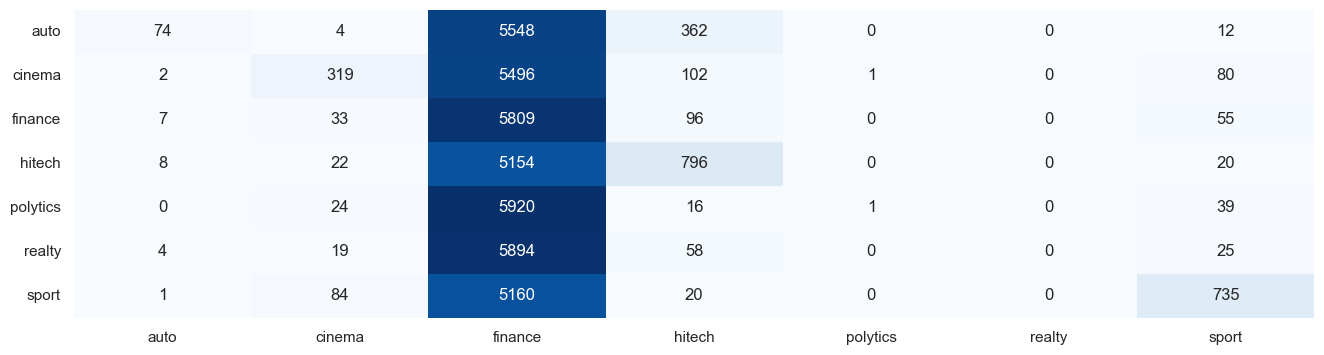

In [73]:
plt.figure(figsize=(16, 4))

sns.heatmap(cm_df, square=False, annot=True, cmap='Blues', fmt='d', cbar=False);

In [77]:
pd.DataFrame(y_preds).value_counts()

finance     38981
hitech       1450
sport         966
cinema        505
auto           96
polytics        2
dtype: int64

Получилась какая-то чушь. То ли нужно было SVC реализацию выбирать и подбирать порог C, то ли вообще параметры по сетке упорно подбирать, то ли я где-то с размерностью векторов запутался. Не буду здесь застревать: мне не нравится ни модель классификации, ни качество эмбедденгов

#### 3.3. FastText Supervised  

Тут сразу учится модель и классификатор. Просто нужно скормить модели набор эталонных текстов и лейблов к ним (по сути трейн датасет) в таком текстовом формате:
 __label__0 some text
__label__1 another text
__label__0 the last text

И всё, обучена и модель эмбеддингов, и классификация!

Ну так давайте сделаем это: 

In [104]:
import fasttext as fasttext

In [103]:
with open('ft_train_data.txt', 'w', encoding="utf-8") as f:
    for pair in list(zip(X_train, y_train)):
        text, label = pair
        f.write(f'__label__{label} {text.lower()}\n')
        
with open('ft_test_data.txt', 'w', encoding="utf-8") as f:
    for pair in list(zip(X_test, y_test)):
        text, label = pair
        f.write(f'__label__{label} {text.lower()}\n')

In [105]:
classifier = fasttext.train_supervised('ft_train_data.txt')#, 'model')
result = classifier.test('ft_test_data.txt')
print('P@1:', result[1])#.precision)
print('R@1:', result[2])#.recall)
print('Number of examples:', result[0])#.nexamples)

P@1: 0.832047619047619
R@1: 0.832047619047619
Number of examples: 42000


Качество получилось чуть похуже, чем у w2v (меньше на 0.8 процентных пункта). Ну и всё, можно предсказывать класс

In [106]:
classifier.predict('А я иду шагаю по Москве')

(('__label__sport',), array([0.96400917]))

Выдаёт кортеж: первый элемент - класс, второй - уверенность модели в этом прогнозе

## 4. Применение модели к нашему датасету

Опускаем как несущественную часть

### 5. Краткие выводы и мысли вслух

* Итак, задача решена - научился многими способами обучать эмбеддинги слов и строить классификаторы w2v и fasttext
* Субъективно, лучшее качество для задач классификации среди этих классов эмбеддингов имеет w2v, обученный на резюме новостей.
* Обучение для задач классификации fasttext модели в unsupervised режиме требует тонкой настройки параметров (преимущественно нижней границы ngramm)
* Похожее качество с w2v даёт fasttext в supervised режиме. Кроме того, он существенно проще (и быстрее) учится и применяется. Но субъективно, я впечатлен w2v и немного разочарован в fasttext.
* Странно, почему мы не изучали здесь же Glove-эмбеддинги - они ведь из этого же семейства, только самые умные ) 